# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [1]:
pip install scikit-learn --upgrade

  Using cached scikit_learn-1.4.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.4.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'COPYING'
Consider using the `--user` option or check the permissions.

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import math

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.neighbors import NearestNeighbors

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

from IPython.display import display

from scipy.spatial import distance

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4512,0,35.0,75200.0,0,0
4500,1,36.0,58900.0,1,0
909,1,36.0,32300.0,0,0
2979,1,21.0,19600.0,0,0
1611,0,48.0,45000.0,2,1
693,1,39.0,34100.0,1,0
2399,0,37.0,27400.0,1,0
3524,1,29.0,48500.0,3,0
3920,0,40.0,38000.0,0,0
24,0,21.0,40400.0,3,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial

# escribe tu conversión aquí si lo deseas:
df['age'] = df['age'].astype(int)

In [8]:
# comprueba que la conversión se haya realizado con éxito
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [9]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?

In [10]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Podemos observar que tenemos un total de 5000 filas de datos, y podemos rescatar la siguiente informacion:
- Los clientes van en un rango de edad desde los 18 a 65 años.
- El rango de ingreso va desde los 5300 hasta 79000
- No todos tienen miembros familiares registrados
- No todos cuentan con los beneficios del seguro

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

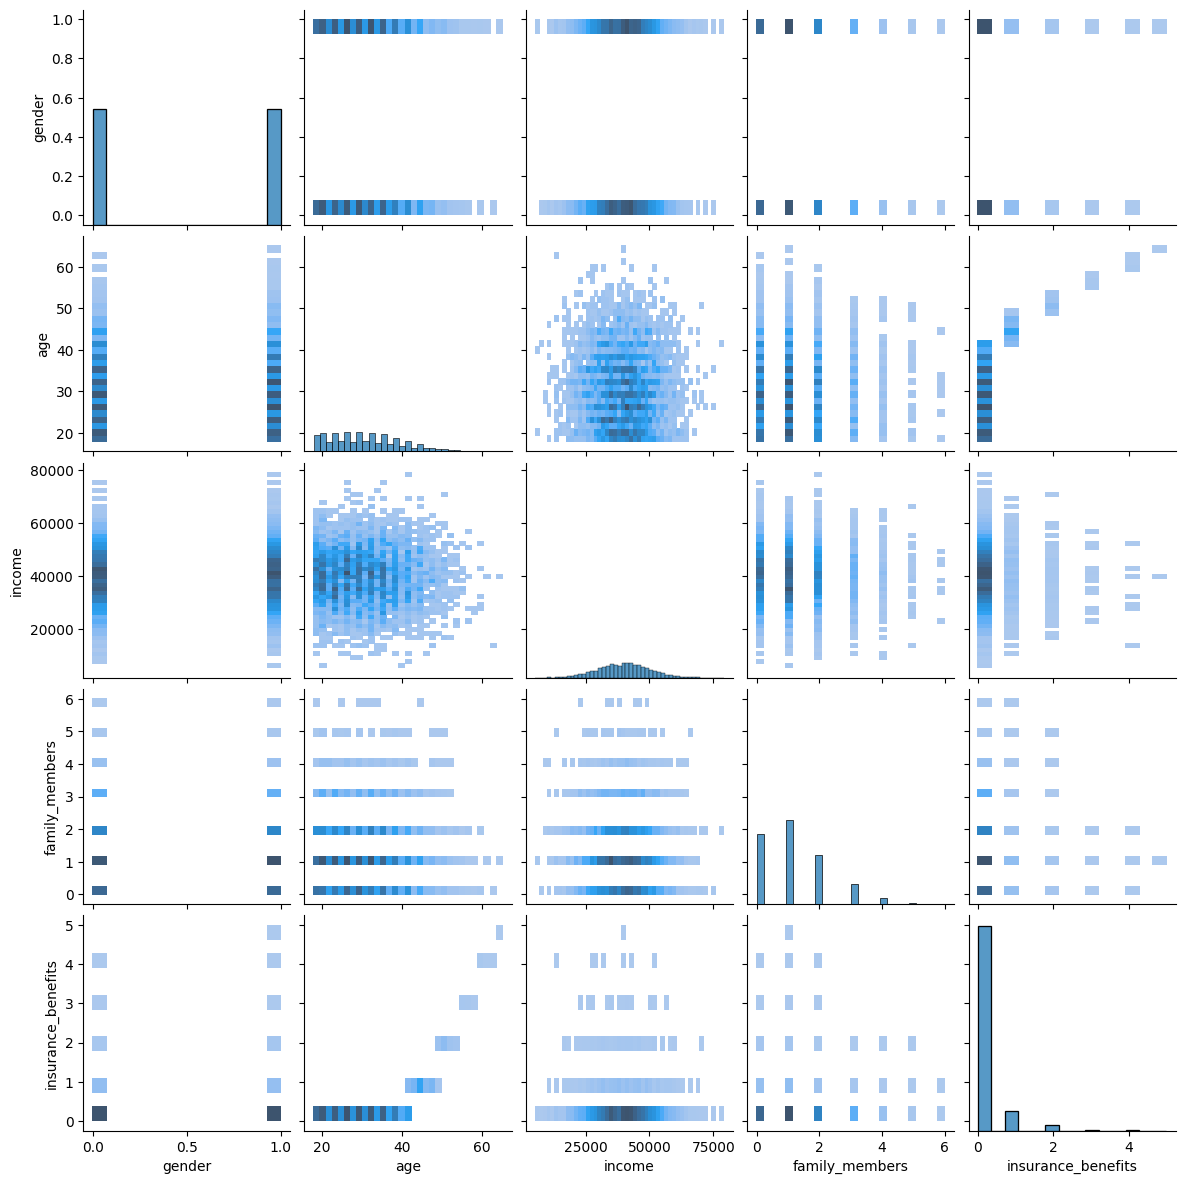

In [11]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.
Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [13]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    
    :param n: número de objetos para los que se buscan los vecinos más cercanos    
    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """
    
    #Dependiendo de la letra que tomara metrica se realizara la metrica Manhattan para la 'M' y Euclidiana para la 'E'
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric) 

    # Ajustar el modelo a los datos
    nbrs.fit(df[feature_names])
    
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalar datos.

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [15]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
2916,0.0,0.476923,0.441772,0.000000,0
2319,1.0,0.600000,0.389873,0.166667,0
4951,0.0,0.523077,0.515190,0.166667,0
2587,1.0,0.400000,0.749367,0.000000,0
682,1.0,0.553846,0.296203,0.500000,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [16]:
knn_01=get_knn(df, 1000, 500, 'manhattan')
knn_01.describe()

,gender,age,income,family_members,insurance_benefits,distance
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.492000,30.900000,42583.600000,1.180000,0.136000,614.580000
std,0.500437,8.280769,690.481404,1.085337,0.462528,337.610066
min,0.000000,18.000000,41400.000000,0.000000,0.000000,0.000000
25%,0.000000,25.000000,42000.000000,0.000000,0.000000,315.000000
50%,0.000000,30.500000,42600.000000,1.000000,0.000000,613.000000
75%,1.000000,36.000000,43200.000000,2.000000,0.000000,907.250000
max,1.000000,60.000000,43800.000000,5.000000,4.000000,1209.000000


In [17]:
knn_02=get_knn(df_scaled, 1000,500, 'manhattan')
knn_02.describe()

,gender,age,income,family_members,insurance_benefits,distance
count,500.0,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1.0,0.573846,0.526499,0.162667,0.230000,0.172969
std,0.0,0.084767,0.077543,0.069876,0.483288,0.060721
min,1.0,0.384615,0.297468,0.000000,0.000000,0.000000
25%,1.0,0.507692,0.474684,0.166667,0.000000,0.133739
50%,1.0,0.584615,0.529114,0.166667,0.000000,0.183236
75%,1.0,0.630769,0.578481,0.166667,0.000000,0.222444
max,1.0,0.815385,0.721519,0.333333,2.000000,0.257157


In [18]:
knn_02=get_knn(df, 1000, 500, 'euclidean')
knn_02.describe()

,gender,age,income,family_members,insurance_benefits,distance
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.492000,30.900000,42583.600000,1.180000,0.136000,602.475113
std,0.500437,8.280769,690.481404,1.085337,0.462528,336.901920
min,0.000000,18.000000,41400.000000,0.000000,0.000000,0.000000
25%,0.000000,25.000000,42000.000000,0.000000,0.000000,300.317332
50%,0.000000,30.500000,42600.000000,1.000000,0.000000,600.120821
75%,1.000000,36.000000,43200.000000,2.000000,0.000000,900.020694
max,1.000000,60.000000,43800.000000,5.000000,4.000000,1200.022083


Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Con los datos escalados obtenemos datos flotantes y todos bajo mayores que 0 pero menores que uno

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

Obtenemos los mismos resultados ya sea con la metrica de distancia Manhattan o la Euclideana

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [19]:
# сalcula el objetivo
df['insurance_benefits_received'] = np.where(df['insurance_benefits']>0,df['insurance_benefits'],0)
target_benefits_received=df[df['insurance_benefits_received']>0].count()/df['gender'].count()

print('Prestacion de seguro recibida(P)=',target_benefits_received['insurance_benefits_received'])

Prestacion de seguro recibida(P)= 0.1128


<AxesSubplot:>

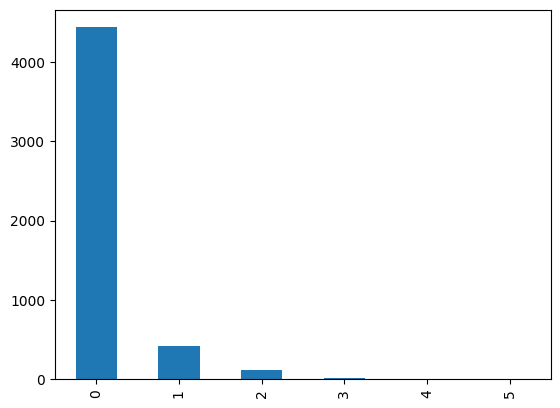

In [20]:
# comprueba el desequilibrio de clases con value_counts()
# <tu código aquí>
df['insurance_benefits_received'].value_counts().plot(kind='bar')

In [21]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, average='weighted')
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo    
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [22]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [23]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P,df['insurance_benefits_received'].sum())    
    eval_classifier=(df['insurance_benefits_received'], y_pred_rnd)
    print()

La probabilidad: 0.00

La probabilidad: 0.15

La probabilidad: 0.50

La probabilidad: 1.00



In [24]:
def evaluate_knn(X_train, X_test, y_train, y_test, n):
    knn = KNeighborsClassifier(n_neighbors=n)
    
    knn.fit(X_train, y_train)
    
    y_pred_knn = knn.predict(X_test)
    result_knn=eval_classifier=(y_test, y_pred_knn)
    return result_knn

In [25]:
def main(df):
    # Escalamos los datos
    feature_names = ['gender', 'age', 'income', 'family_members']

    transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

    df_scaled = df.copy()
    df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())
    
    # Como obtendremos los conjuntos con proporcion 70:30 realizaremos un conjunto de entrenamiento y otro de pruebas
    train,test=train_test_split(df_scaled,test_size=0.25,random_state=54321)
    #Entrenamiento
    X_train=train.drop(['insurance_benefits_received'],axis=1)
    y_train=train['insurance_benefits_received']
    #Prueba
    X_test=test.drop(['insurance_benefits_received'],axis=1)
    y_test=test['insurance_benefits_received']
    
    result_knn=evaluate_knn(X_train, X_test, y_train, y_test, 5)
    print(result_knn)

In [26]:
main(df)

(3893    1
1201    0
1       1
1353    0
3110    0
       ..
1061    0
3407    0
786     0
1066    0
1031    0
Name: insurance_benefits_received, Length: 1250, dtype: int64, array([1, 0, 1, ..., 0, 0, 0]))


# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [27]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        
        #w=np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.weights =np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        #self.w0 = w[0]

    def predict(self, X):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred =X2.dot(self.weights)
        
        return y_pred

In [28]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [29]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [30]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [31]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [32]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

Una matriz es invertible si y sólo si su determinante es distinto de cero. Esto es, una matriz tiene inversa si su determinante es no cero.

La matriz P cuadrada seria invertible si existe una matriz B con la propiedad de que:

P*B=B*P=I

donde I es la matriz identidad. La matriz B es única, la llamamos la inversa de P y la denotamos por P':

P*P'=P'*P=I

¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

In [33]:
print(X.dot(P))

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


No puedo adiviinar ya que son solo datos numericos solamente.

¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

In [34]:
#X_2= rng.random(size=(P.shape[1], P.shape[1]))

print('Datos originales:')
print(X)

print('')
print('Datos transformados')
print(np.dot(X,P))

print('')
print('Intento de recuperar datos originales)')
print(np.dot(np.dot(X,P),np.linalg.inv(P)))

Datos originales:
[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]

Datos transformados
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]

Intento de recuperar datos originales)
[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 ...
 [-1.92837871e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.200

Solo algunos datos fueron recuperdos correctamente como se ve en la primera fila de los datos originales y recuperados.

Muestra los tres casos para algunos clientes- Datos originales
- El que está transformado- El que está invertido (recuperado)

Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

- Sabemos que el resultado de la multiplicación de matrices depende del orden de los multiplicadores y al transformarlos estos cambian.

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta**

- Si simplificamos la formula de  $w_P \times P$ nos quedarian los mismos bases datos que seria la X
- Los valores predictivos de $w_P$ deberian ser los mismos que los de $w$ ya que la variable $y$ es la misma.
- Deberian tener el mismo RECM ya que esta es una media de error cuadratico, es decir, mide el procentaje de error entre los datos entrenados y las predicciones, deberian ser proporcionales un modelo del otro ya que las predicciones son las mismas.

**Prueba analítica**

Al entrenar 2 modelos de regresion lineal, uno con los datos normales y otro con los datos ofuscados, deberiamos tener bastantes similitudes como es el caso del RCEM pero al ver las $w$ de cada uno deberia haber una difrencia importante y es que ademas de tener valores diferentes, esos mismos valores deberian ser negativos ya que $P$ es la matriz invertida de $X$

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

In [35]:
# New Matrix
def invertible_matrix(n):

    # Random matrix-size n x n
    P = np.random.rand(n, n)

    # While not inverse
    while np.linalg.matrix_rank(P) != n:

        # Create new random matrix
        P = np.random.rand(n, n)

    # Return when inverse
    return P



In [36]:
# Declaramos las nuevas variables
X = np.random.rand(100,5)
y = np.random.rand(100)
P=invertible_matrix(X.shape[1])
X_obfuscated=np.dot(X,P)

# Conjuntos de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)
X_obfuscated_train, X_obfuscated_test, y_obfuscated_train, y_obfuscated_test = train_test_split(X_obfuscated, y, test_size=0.3, random_state=12345)

# Creacion de modelos
lr = MyLinearRegression()
lr_obfuscated=MyLinearRegression()

# Entrenamiento de modelos
lr.fit(X_train, y_train)
lr_obfuscated.fit(X_obfuscated_train,y_obfuscated_train)

# Mostramos el modelo
print("Modelo de regresion lineal")
print(lr.weights)
print()
print("Modelo de regresion lineal ofuscado")
print(lr_obfuscated.weights)
print()
# Predicciones de los modelos
y_test_pred = lr.predict(X_test)
y_obfuscated_test_pred=lr_obfuscated.predict(X_obfuscated_test)
# Mostramos RMSE
print("RMSE para modelo de regresion lineal")
rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_test, y_test_pred))
print(rmse)
print()
print("RMSE para modelo de regresion lineal ofuscado")
rmse_obfuscated = math.sqrt(sklearn.metrics.mean_squared_error(y_obfuscated_test, y_obfuscated_test_pred))
print(rmse_obfuscated)

Modelo de regresion lineal
[ 0.56035165  0.0637535   0.03017354 -0.12247539 -0.21470155  0.0166849 ]

Modelo de regresion lineal ofuscado
[ 0.56035165 -2.74979887 -0.08769457  3.32324646  0.26295993 -2.25549367]

RMSE para modelo de regresion lineal
0.27378541385391164

RMSE para modelo de regresion lineal ofuscado
0.2737854138538305


# Conclusiones

Realizamos un modelo lineal con un DataFrame y otro con datos aleatorios.

El modelo con el DataFrame al realizar la ofuscacion y otros procesos no me permitio una vision clara de la totalidad de los datos en si por lo que la usaria en casos de que necesite trabajar con una columna de datos especifica y obtener metricas y estadisticas de este.

El modelo con datos aleatorios me permitio experimentar y saber que los datos pueden ser regresados a su forma original y que tambien podemos obtener datos similares siempre y cuando las predicciones(y) se mantengan y los datos(X) 

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>